Author: JLINDSEY
Date: 2025/05/16
File Name: disease_predictions.py
Source: https://www.geeksforgeeks.org/disease-prediction-using-machine-learning/

In [13]:
#-------------------------------------------------
# Import Libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from statistics import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

Resample Class Distribution:/n disease
29    90
11    90
4     90
18    90
23    90
1     90
12    90
30    90
32    90
9     90
20    90
36    90
15    90
19    90
27    90
3     90
25    90
0     90
5     90
22    90
35    90
31    90
16    90
24    90
7     90
17    90
34    90
10    90
37    90
6     90
33    90
21    90
26    90
13    90
28    90
14    90
8     90
2     90
Name: count, dtype: int64


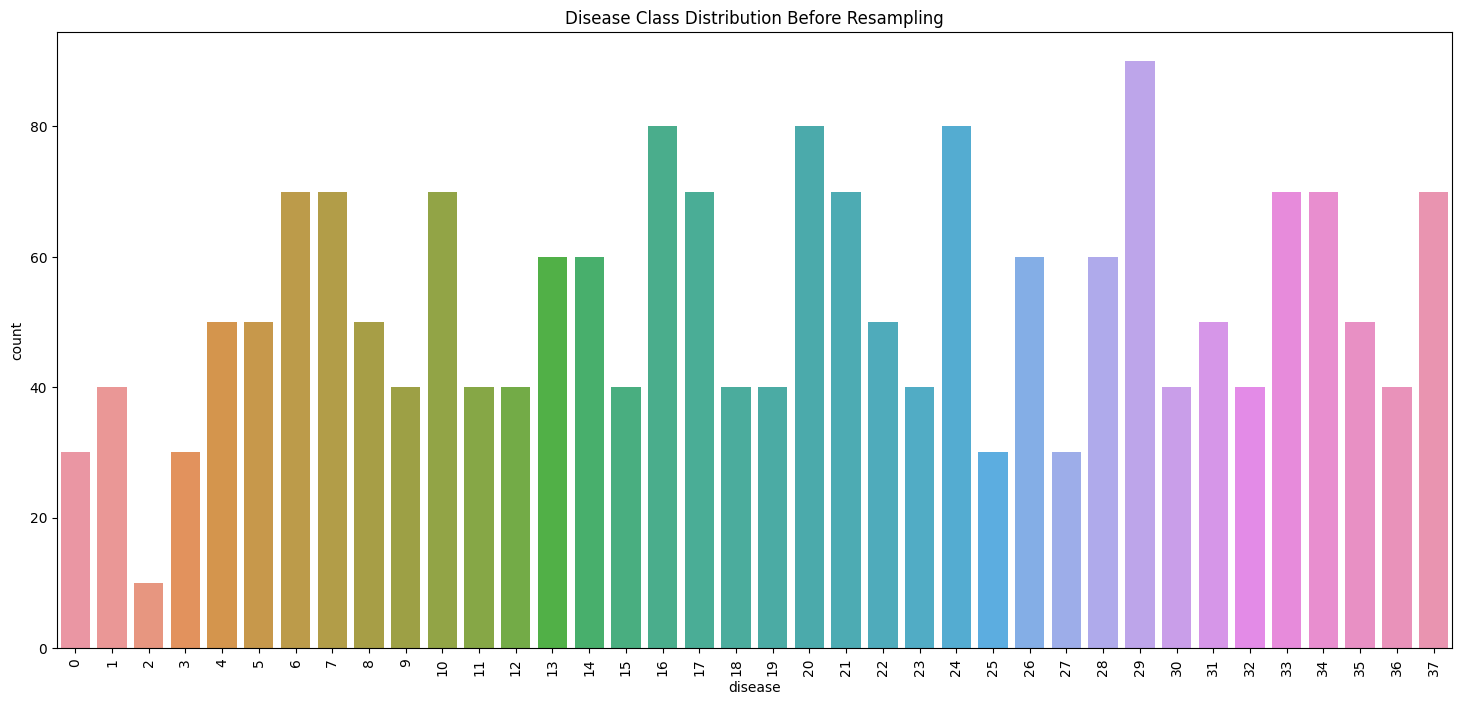

In [14]:
#-------------------------------------------------
#Read the Dataset
data = pd.read_csv('improved_disease_dataset.csv')

encoder = LabelEncoder()
data['disease'] = encoder.fit_transform(data['disease'])

x = data.iloc[:,:-1]
y = data.iloc[:,-1]

plt.figure(figsize = (18,8))
sns.countplot(x=y)
plt.title("Disease Class Distribution Before Resampling")
plt.xticks(rotation = 90)
#plt.show()


ros = RandomOverSampler(random_state = 42)
x_resampled, y_resampled = ros.fit_resample(x,y)

print("Resample Class Distribution:/n", pd.Series(y_resampled).value_counts())

In [15]:
#-------------------------------------------------
# Cross-Validation w/ Stratified K-Fold

if 'gender' in x_resampled.columns:
    le = LabelEncoder()
    x_resampled['gender'] = le.fit_transform(x_resampled['gender'])

x_resampled = x_resampled.fillna(0)

if len(y_resampled.shape) > 1:
    y_resampled = y_resampled.values.ravel()

models = {
    "SVM": SVC(),
    "Desicion Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

cv_scoring = 'accuracy' # can also you: 'f1_weightd', 'roc_auc_over', for multi-class
stratified_kfold = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)

for model_name, model in models.items():
    try:
        scores = cross_val_score(
            model, 
            x_resampled,
            y_resampled,
            cv = stratified_kfold,
            scoring = cv_scoring, 
            n_jobs = -1,
            error_score='raise'
        )
        print("=" * 50)
        print("Model: {}".format(model_name))
        print("Scores: {}".format(scores))
        print("Mean Accuracy: {:.4f}".format(scores.mean()))
    except Exception as e:
        print("=" * 50)
        print("Model: {} failed with error".format(model_name))
        print(e)

# The output shows the evaluation results for three models, SVC, Gaussian Naive Bayes, and Random Forest using cross-validation.


Model: SVM
Scores: [0.51315789 0.51169591 0.49707602 0.48245614 0.49561404]
Mean Accuracy: 0.5000
Model: Desicion Tree
Scores: [0.5497076  0.54532164 0.53216374 0.53654971 0.52777778]
Mean Accuracy: 0.5383
Model: Random Forest
Scores: [0.55847953 0.54824561 0.53508772 0.53362573 0.51900585]
Mean Accuracy: 0.5389


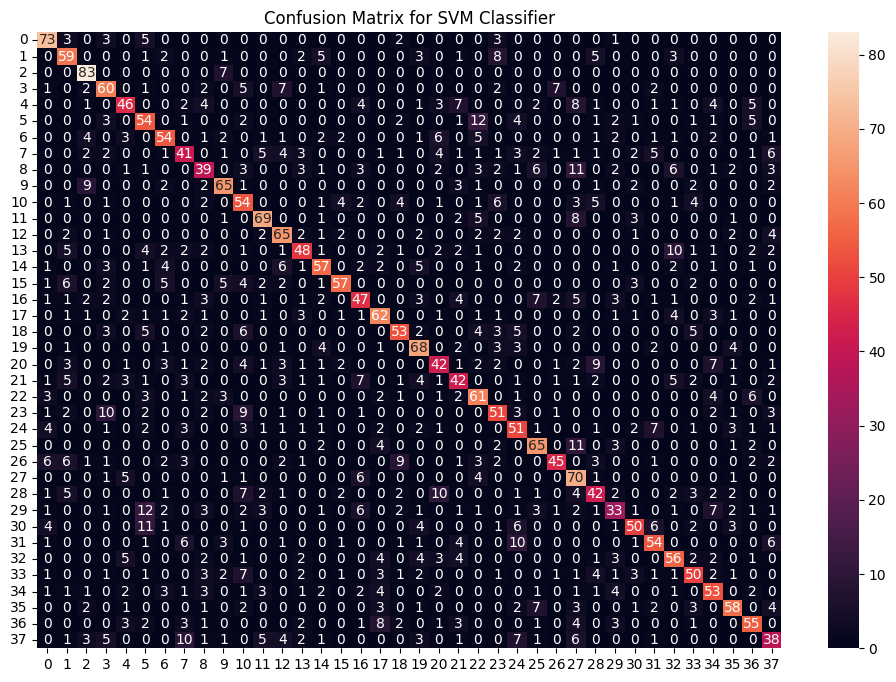

SVM Accuracy: 60.53%


In [16]:
#-------------------------------------------------
# Training Individual Models and Generating Confusion Matrices

# Support Vector Classifier (SVC)

svm_model = SVC()
svm_model.fit(x_resampled, y_resampled)
svm_preds = svm_model.predict(x_resampled)

cf_matrix_svm = confusion_matrix(y_resampled, svm_preds)
plt.figure(figsize = (12,8))
sns.heatmap(cf_matrix_svm, annot = True, fmt='d')
plt.title("Confusion Matrix for SVM Classifier")
plt.show()

print("SVM Accuracy: {:.2f}%".format(accuracy_score(y_resampled, svm_preds) * 100))

# The matrix shows good accuracy with most values along the diagonal meaning the SVm model predicted the correct classs most of the time

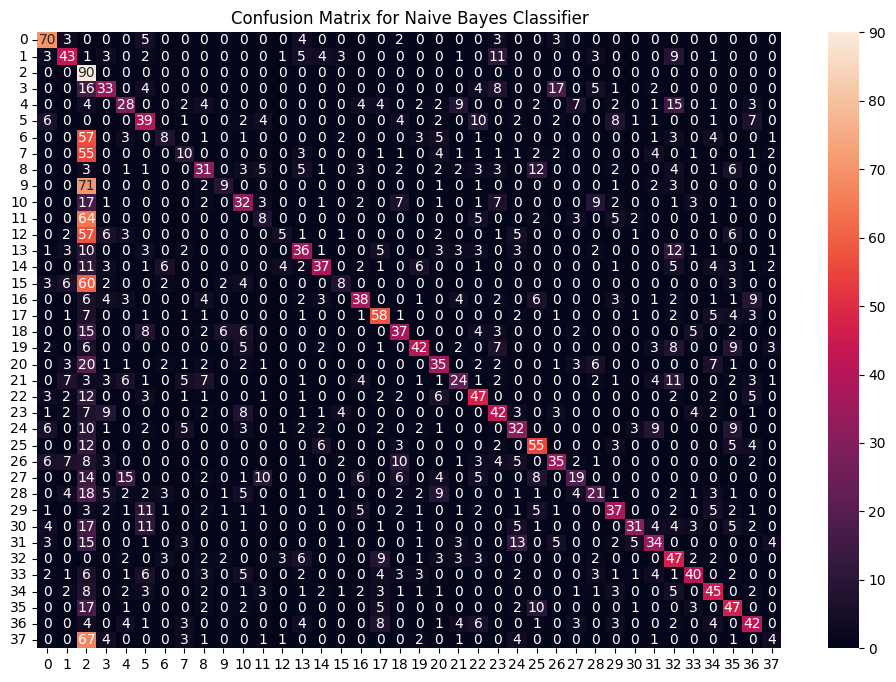

Naive Bayes Accuracy: 37.98%


In [17]:
# Gaussian Naive Bayes

nb_model = GaussianNB()
nb_model.fit(x_resampled, y_resampled)
nb_preds = nb_model.predict(x_resampled)

cf_matrix_nb = confusion_matrix(y_resampled, nb_preds)
plt.figure(figsize = (12,8))
sns.heatmap(cf_matrix_nb, annot = True, fmt='d')
plt.title("Confusion Matrix for Naive Bayes Classifier")
plt.show()

print("Naive Bayes Accuracy: {:.2f}%".format(accuracy_score(y_resampled, nb_preds) * 100))

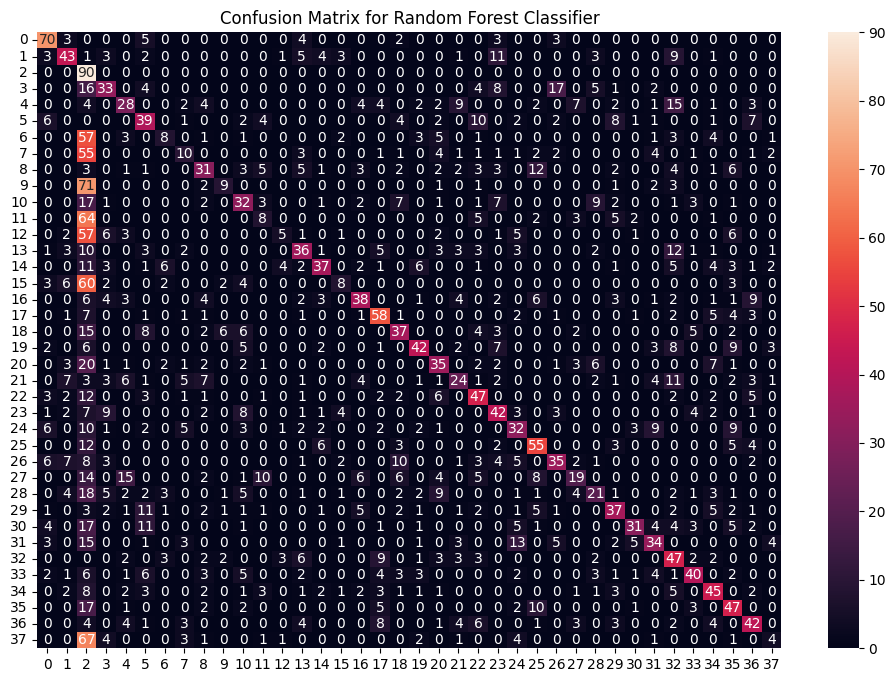

Random Forest Accuracy: 37.98%


In [18]:
# Random Forest Classifier

rf_model = GaussianNB()
rf_model.fit(x_resampled, y_resampled)
rf_preds = rf_model.predict(x_resampled)

cf_matrix_rf = confusion_matrix(y_resampled, rf_preds)
plt.figure(figsize = (12,8))
sns.heatmap(cf_matrix_rf, annot = True, fmt='d')
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

print("Random Forest Accuracy: {:.2f}%".format(accuracy_score(y_resampled, rf_preds) * 100))

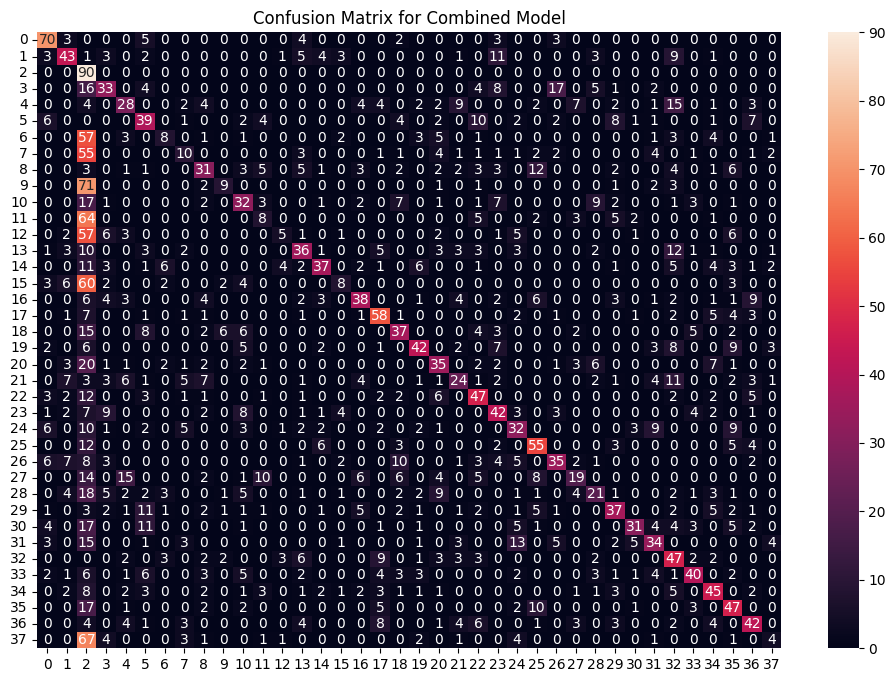

Combined Model Accuracy: 37.98%


In [19]:
#-------------------------------------------------
# Combining Predictions for Robustness

final_preds = [mode([i,j,k]) for i,j,k in zip(svm_preds, nb_preds, rf_preds)]

cf_matrix_combined = confusion_matrix(y_resampled, final_preds)
plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix_combined, annot=True, fmt='d')
plt.title("Confusion Matrix for Combined Model")
plt.show()

print("Combined Model Accuracy: {:.2f}%".format(accuracy_score(y_resampled, final_preds) * 100))

In [24]:
# Creating Prediction Functions

symptoms = x.columns.values
symptom_index = {symptom: idx for idx, symptom in enumerate(symptoms)}

def predict_disease(input_symptoms):
    input_symptoms = input_symptoms.split(",")
    input_data = [0] * len(symptom_index)

    for symptom in input_symptoms:
        if symptom in symptom_index:
            input_data[symptom_index[symptom]] = 1

    input_data = np.array(input_data).reshape(1, -1)

    # Generate predictions
    rf_pred = encoder.classes_[rf_model.predict(input_data)[0]]
    nb_pred = encoder.classes_[nb_model.predict(input_data)[0]]
    svm_pred = encoder.classes_[svm_model.predict(input_data)[0]]

    # Final prediction
    final_pred = mode([rf_pred, nb_pred, svm_pred])

    return {
        "Random Forest Prediction": rf_pred,
        "Naive Bayes Prediction": nb_pred,
        "SVM Prediction": svm_pred,
        "Final Prediction": final_pred
    }

print(predict_disease("Itching,Skin Rash,Nodal Skin Eruptions"))

{'Random Forest Prediction': 'Urinary tract infection', 'Naive Bayes Prediction': 'Urinary tract infection', 'SVM Prediction': 'Impetigo', 'Final Prediction': 'Urinary tract infection'}


c:\Users\Joshua\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\Joshua\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\Joshua\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
